In [2]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pymc as pm
import arviz as az

<center>

# **Universidade de São Paulo**  
## *ICMC - Instituto de Ciências Matemáticas e Computação*  
### Curso: Estatística e Ciência de Dados

<br><br>

# **Análise do Impacto do Tamanho da Amostra na Inferência Bayesiana**

<br><br>

**Aluna:** Ana Rosa Almeida do Nascimento\
**N° USP:** _______\
**Professor:** Vicente Cancho\
**Disciplina:** Inferência Bayesiana

<br>
    
**São Carlos - SP**  
**Setembro de 2025**

</center>

## Atividade 1

Investigar como o tamanho da amostra $n$ influencia a distribuição a priori dos parâmetros de um modelo estatístico, comparando três abordagens para escolha da priori:

- Priori conjugada (informativa)
- Priori de Jeffreys (não informativa)
- Priori hierárquica (flexível)

Modelo estatístico escolhido:
$$
X|\lambda \text{ ~ } Poisson(\lambda)
$$

Na atividade, escolheremos $Poisson(\lambda)$ com $\lambda = 5$. O EMV de $\lambda$ para a Poisson é a média amostral.

$$
p_{x|\lambda}(x|\lambda) = \frac{e^{-\lambda} \lambda^x}{x!}, \,\lambda > 0 \text{ e } x = 1,...,n
$$

Priori conjugada: 

$$
\lambda \text{ ~ } Gama(\alpha, \beta)
$$

$$
p(\lambda) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}, \, \alpha, \beta > 0 \text{ e } \lambda > 0
$$

Com $\alpha = 15$ e $\beta = 3$, pois $E(\lambda) = \frac{\alpha}{\beta} = 5$.

Priori de Jeffreys: 

$$
p(\lambda) \propto \lambda^{-1/2}
$$

Priori hierarquica: 

Para a priori hierárquica, escolheremos $\alpha$ e $\beta$ seguindo exponenciais com parâmetros tais que $\frac{E(\alpha)}{E(\beta)} = 5$. Isto pois a média da gama é $E(\lambda) = \frac{\alpha}{\beta}$ e queremos que o estimador via Bayes seja o mais próximo possível da média amostral (pois o estimador de $\lambda$ para Poisson é $\bar{X}$)

$$
\lambda|\alpha,\beta \text{ ~ }  Gama(\alpha, \beta)
$$

$$
p(\lambda|\alpha,\beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}, \, \alpha, \beta > 0 \text{ e } \lambda > 0
$$

Onde
$$
\alpha \text{ ~ } Exp(\frac{1}{15})\\
\beta \text{ ~ } Exp(\frac{1}{3})
$$

$$
p(\alpha) = \frac{1}{15}e^{-\frac{1}{15}\alpha}, \alpha > 0
$$

$$
p(\beta) = \frac{1}{3}e^{-\beta\frac{1}{3}}, \beta > 0
$$


## Propriedades de uma Gama

As duas primeiras priori são o núcleo de uma gama, logo, apresentaremos algumas definições úteis:

### Esperança

Dado que a Gama é a soma de $\alpha$ v.a. exponenciais Y com E($Y_i$) = $\frac{1}{\beta}$, temos
$$
E(X) = E(\sum_{i = 1}^{\alpha} Y_i) = \sum_{i = 1}^{\alpha} E(Y_i) = \frac{\alpha}{\beta}
$$

### Variância
Analogamente, a variância é calculada dada as variâncias da v.a. independentes Var($X_i$) = $\frac{\alpha}{\beta^2}$
 
$$
Var(X) = Var(\sum_{i = 1}^{\alpha} Y_i) = \sum_{i = 1}^{\alpha} Var(Y_i) = \frac{\alpha}{\beta^2}
$$

### Moda

$$
Moda(X) = \frac{\alpha - 1}{\beta}
$$

Quando $\alpha \geq 1$.

### Mediana (Aproximação)

Para $\alpha \geq 1$:

$$
Mediana(X) = \frac{\alpha - 1/3}{\beta}
$$

In [ ]:
# Gerando amostra aleatória de Poisson com parâmetro 5 de diferentes tamanhos

amostra1 = st.poisson.rvs(mu=5,size=5, random_state=1111)
amostra2 = st.poisson.rvs(mu=5,size=10, random_state=1112)
amostra3 = st.poisson.rvs(mu=5,size=100, random_state=1113)
amostra4 = st.poisson.rvs(mu=5,size=500, random_state=1114)

lista_amostras = [amostra1, amostra2,amostra3,amostra4]

In [12]:
# cores por tamanho de amostra

cor_amostra = ['#4c8fd5','#4caf50','#f06292','#ffeb3b']

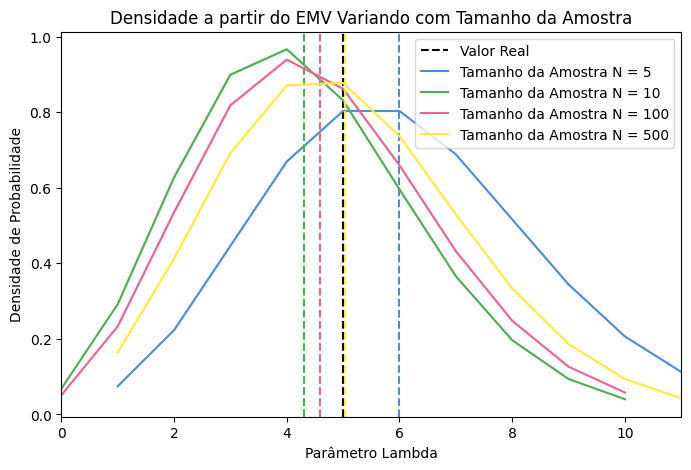

In [21]:
# Com inferência clássica

plt.figure(figsize=(8,5))
#plt.hist(x)

a = 15
b = 3
plt.axvline(x=a/b, color='black', linestyle='--', label='Valor Real')

i = 0
                
for amostra in lista_amostras:
    x = amostra
    n = len(x)
    
    suporte = np.linspace(0,10,1000)

    x_poisson = st.poisson.ppf(np.linspace(0.01,0.99,100), mu = sum(x)/n)
    y_poisson = st.poisson.pmf(x_poisson, mu = sum(x)/n)
    df_poisson = pd.DataFrame({'x': x_poisson, 'p_x': y_poisson})
    df_poisson['p_x escala'] = df_poisson['p_x']*len(amostra1)
    sns.lineplot(data = df_poisson, x = 'x', y = 'p_x escala', label=f'Tamanho da Amostra N = {n}', color=cor_amostra[i])
    plt.axvline(x = sum(x)/n, linestyle='--', color=cor_amostra[i])
        
    i +=1
plt.xlim(0,11)
plt.title('Densidade a partir do EMV Variando com Tamanho da Amostra')
plt.xlabel('Parâmetro Lambda')
plt.ylabel('Densidade de Probabilidade')
plt.legend(loc='upper right')

## Definição da Priori Conjugada (Informativa)

Considere uma amostra $X = (X_1,...,X_n)$ variáveis independentes e identicamente distribuídas com densidade $Poisson(\lambda),\, \lambda > 0$ e verossimilhança $L(x|\lambda)$. Uma priori conjugada é uma priori tal que, dada a função de verossimilhança, a distribuição a posteriori pertença à mesma classe da priori. Ou seja, definindo $F = {p(x|\lambda), \lambda \in \Theta}$ uma classe de distribuições então uma classe de distribuições $P$ é conjugada a $F$ se 

$$
\forall L(x|\lambda) \in F \text{ e } p_\lambda(\lambda) \in P  \rightarrow L(x|\lambda) \in P
$$

Além disso, precisa respeitar:

1. $P$ é fechado por amostragem, ou seja, se $\forall p_1, p_2 \in P \,\exists \,k$ tal que $k p_1 p_2 \in P$

Se existe uma constante $k$ tal que $k^{-1} = \int p(\lambda | x) d \lambda < \infty$

Para a atividade proposta, usarei uma Poisson para encontrar a conjugada:

$$
p(x|\lambda) = \frac{e^{-\lambda} \lambda^x}{x!} \propto e^{-\lambda} \lambda^x
$$

Com verossimilhança:

$$
L(x|\lambda) = \prod_{i=1}^n \frac{e^{-\lambda} \lambda^x_i}{x_i!} \propto e^{-n\lambda} \lambda^{\sum_{i=1}^n x_i}
$$

Podemos ver que a primeira é o núcleo de uma Gama com parâmetros $\alpha = x + 1$ e $\beta = 1$ e a segunda uma Gama com $\alpha =\sum_{i=1}^n x_i + 1$ e $\beta = n$. Logo, uma conjugada para a priori é uma distribuição Gama, que é fechada por amostragem. Então,

$$
\lambda \text{ ~ } Gama(\alpha, \beta)
$$

$$
p(\lambda) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}, \, \alpha, \beta > 0 \text{ e } \lambda > 0
$$


A vantagem neste tipo de Priori é que apenas atualizaremos os parâmetros com os dados, sem modificar a distribuição presente.

Logo, a densidade a posteriori é

$$
p_{x|\lambda}(x|\lambda) \propto L(x|\lambda) p(\lambda) = e^{-n\lambda} \lambda^{\sum_{i=1}^n x_i} \prod_{i=1}^n \frac{1}{x_i!} \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda} \propto e^{-n\lambda} \lambda^{\sum_{i=1}^n x_i} \lambda^{\alpha - 1} e^{-\beta \lambda} = \lambda^{\sum_{i=1}^n x_i + \alpha - 1} e^{-\lambda(n + \beta)}
$$

Que é o núcleo de uma $Gama(\sum_{i=1}^n x_i + \alpha, n + \beta)$, onde $\alpha = 15$ e $\beta = 3$

In [58]:
def posteriori_conjugada(a,b,x,n):
    
    suporte = np.linspace(0,100,1000)
    alfa = sum(x) + a
    beta = n + b
    prob = st.gamma.pdf(a = alfa, scale = 1/beta, x=suporte)
    
    return pd.DataFrame({'x':suporte, 'p_x':prob})

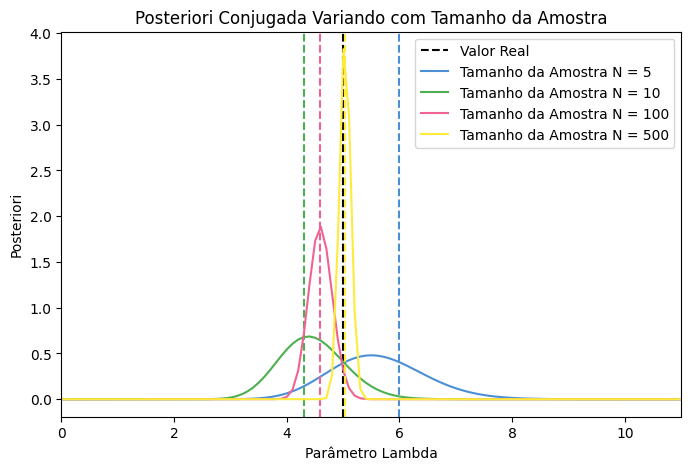

In [59]:
plt.figure(figsize=(8,5))

a = 15
b = 3
plt.axvline(x=a/b, color='black', linestyle='--', label='Valor Real')

i = 0
                
for amostra in lista_amostras:
    x = amostra
    n = len(x)
    
    suporte = np.linspace(0,10,1000)

    df_gama = posteriori_conjugada(a,b,x,n)
    sns.lineplot(data = df_gama, x = 'x', y = 'p_x', label=f'Tamanho da Amostra N = {n}', color=cor_amostra[i])
    plt.axvline(x = sum(x)/n, linestyle='--', color=cor_amostra[i])
        
    i +=1
plt.xlim(0,11)
plt.title('Posteriori Conjugada Variando com Tamanho da Amostra')
plt.xlabel('Parâmetro Lambda')
plt.ylabel('Posteriori')
plt.legend(loc='upper right')

## Definição da Priori de Jeffreys (Não Informativa)

Neste tipo de priori, a informação dos dados é dominante, então a informação a priori é vaga. Pode-se usar uma distribuição onde a probabilidade de todos os possíveis valores de $\lambda$ sejam iguais. Um exemplo seria uma uniforme.

A priori de Jeffreys utiliza a informação de Fisher como a priori. Logo

$$
J(\lambda) = \sqrt{I^*_{F}(\lambda)}
$$

Onde
$$
I^*_{F}(\lambda) = nI_{F}(\lambda) = -n E( \frac{\partial ^2 log p_{X|\lambda}(x|\lambda)}{\partial \lambda^2 })
$$

Ou seja, a informação de Fisher para uma amostra de $(X_1,...,X_n)$ é a informação de Fisher de $X_i$ n vezes, quando a amostra é de variáveis aleatórias independentes e identicamente distribuídas.

Para a atividade, a priori de Jeffreys para $X \text{ ~ } Poi(\lambda)$ é

$$
J(\lambda) = \sqrt{I^*_{F}(\lambda)}
$$

A log da densidade é

$$
log p_{X|\lambda}(x|\lambda) = -\lambda + x. log(\lambda) - log(x!) \rightarrow \frac{\partial log p_{X|\lambda}(x|\lambda)}{\partial \lambda} = -1 + \frac{x}{\lambda}
$$

A segunda derivada em relação à $\lambda$ é

$$
\frac{\partial ^2 log p_{X|\lambda}(x|\lambda)}{\partial \lambda^2 } = (-1)x\lambda^{-2} = -x\lambda^{-2}
$$

A esperança é

$$
E(\frac{\partial ^2 log p_{X|\lambda}(x|\lambda)}{\partial \lambda^2 }) = \frac{E(X)}{\lambda^{2}}
$$

Como $X$ é uma poisson com parâmetro $\lambda$, sua média é o parâmetro $\lambda$ e, portanto

$$
\frac{E(X)}{\lambda^{2}} = \frac{\lambda}{\lambda^2} = \frac{1}{\lambda} = \lambda^{-1}
$$

Logo, a informação de Fisher é

$$
I^*_{F}(\lambda) = nI_{F}(\lambda) = -n E( \frac{\partial ^2 log p_{X|\lambda}(x|\lambda)}{\partial \lambda^2 }) = \frac{n}{\lambda} = n\lambda^{-1}
$$

Logo, a priori de Jeffreys é

$$
p(\lambda) = \sqrt{n\lambda^{-1}} \propto \lambda^{\frac{-1}{2}}
$$

A mesma é imprópria pois quando $\lambda \to \infty$ a integral diverge.

E a posteriori será

$$
p_{x|\lambda}(x|\lambda) \propto L(x|\lambda) p(\lambda) = e^{-n\lambda} \lambda^{\sum_{i=1}^n x_i} \prod_{i=1}^n \frac{1}{x_i!} \lambda^{\frac{-1}{2}} \propto e^{-n\lambda}  \lambda^{\sum_{i=1}^n x_i - \frac{1}{2}}
$$

Que é o núcleo de uma $Gama(\sum_{i=1}^n x_i + \frac{1}{2}, n)$

In [60]:
def posteriori_jeffreys(a,b,x,n):
    
    suporte = np.linspace(0,100,1000)
    alfa = sum(x) + 1/2
    beta = n
    prob = st.gamma.pdf(a = alfa, scale = 1/beta, x=suporte)
    
    return pd.DataFrame({'x':suporte, 'p_x':prob})

Text(0, 0.5, 'Posteriori')

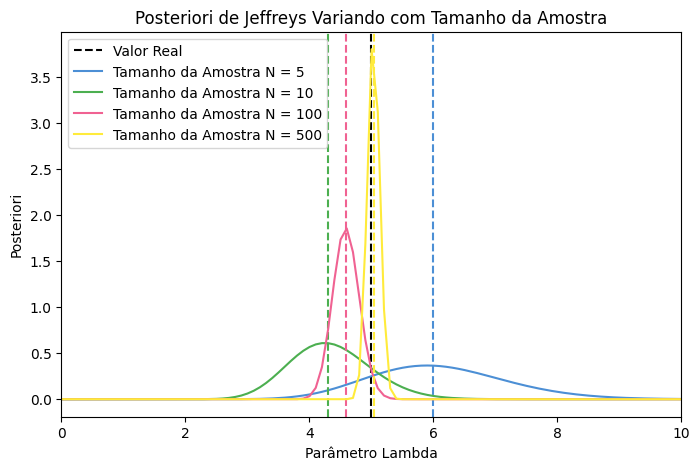

In [61]:
plt.figure(figsize=(8,5))

a = 15
b = 3
plt.axvline(x=a/b, color='black', linestyle='--', label='Valor Real')

i = 0
                
for amostra in lista_amostras:
    x = amostra
    n = len(x)
    
    suporte = np.linspace(0,10,1000)

    df_gama = posteriori_jeffreys(a,b,x,n)
    sns.lineplot(data = df_gama, x = 'x', y = 'p_x', label=f'Tamanho da Amostra N = {n}', color=cor_amostra[i])
    plt.axvline(x = sum(x)/n, linestyle='--', color=cor_amostra[i])
        
    i +=1
plt.xlim(0,10)
plt.title('Posteriori de Jeffreys Variando com Tamanho da Amostra')
plt.xlabel('Parâmetro Lambda')
plt.ylabel('Posteriori')

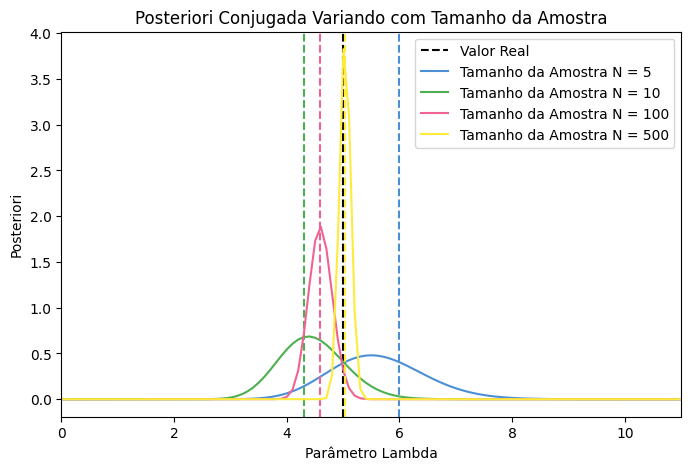

In [62]:
plt.figure(figsize=(8,5))

a = 15
b = 3
plt.axvline(x=a/b, color='black', linestyle='--', label='Valor Real')

i = 0
                
for amostra in lista_amostras:
    x = amostra
    n = len(x)
    
    suporte = np.linspace(0,10,1000)

    df_gama = posteriori_conjugada(a,b,x,n)
    sns.lineplot(data = df_gama, x = 'x', y = 'p_x', label=f'Tamanho da Amostra N = {n}', color=cor_amostra[i])
    plt.axvline(x = sum(x)/n, linestyle='--', color=cor_amostra[i])
        
    i +=1
plt.xlim(0,11)
plt.title('Posteriori Conjugada Variando com Tamanho da Amostra')
plt.xlabel('Parâmetro Lambda')
plt.ylabel('Posteriori')
plt.legend(loc='upper right')

## Definição da Priori Hierárquica

Nesta priori, o parâmetro segue uma distribuição com outros parâmetros, chamados hiperparâmetros, dividindo a distribuição em estágios. É uma abordagem interessante quando o parâmetro segue um modelo de mistura. A densidade a posteriori será a verossimilhança com a priori do parâmetro e as hiperpriori dos hiperparâmetros. Temos

$$
\lambda|\alpha,\beta \text{ ~ }  Gama(\alpha, \beta)
$$

$$
p(\lambda|\alpha,\beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}, \, \alpha, \beta > 0 \text{ e } \lambda > 0
$$

No nosso problema, $\alpha$ deve estar concentrado em $15$ e $\beta$ em $3$, tal que a esperança da gama seja $5$:

$$
E(\alpha) = 15\\
E(\beta) = 3
$$

Logo, a exponencial para esta situação seria

$$
\alpha \text{ ~ } Exponencial(1/15)\\
\beta \text{ ~ } Exponencial(1/3)
$$


A priori conjunta é

$$
p(\lambda, \alpha,\beta) = p(\lambda|\alpha,\beta) p(\alpha) p(\beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda} \frac{1}{15}e^{-\frac{1}{15}\alpha} \frac{1}{3}e^{-\frac{1}{3}\beta} \,\,\,\,\,\,\, (1)
$$

Com $\alpha, \beta, \lambda > 0$


Logo, a densidade a posteriori é

$$
p_{\lambda, \alpha,\beta | x}(\lambda,\alpha,\beta | x) \propto L(x|\lambda) p(\lambda,\alpha,\beta) = e^{-n\lambda} \lambda^{\sum_{i=1}^n x_i} \prod_{i=1}^n \frac{1}{x_i!}  \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda} \frac{1}{15}e^{-\frac{1}{15}\alpha} \frac{1}{3}e^{-\frac{1}{3}\beta} \propto \frac{\beta^{\alpha}}{\Gamma(\alpha)}  e^{-n\lambda - \frac{\alpha}{15} - \beta(\frac{1}{3} + \lambda)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1}
$$

Logo, 

$$
p_{\lambda, \alpha,\beta |x}(\lambda,\alpha,\beta | x) \propto  \frac{\beta^{\alpha}}{\Gamma(\alpha)}  e^{-n\lambda - \frac{\alpha}{15} - \beta(\frac{1}{3} + \lambda)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1}
$$

Que não tem forma fechada. Para estimar a distribuição, usaremos Monte Carlo.

A densidade a posteriori completa é

$$
p_{\lambda, \alpha,\beta | x}(\lambda,\alpha,\beta | x) =  k{\prod_{i=1}^n \frac{1}{x_i!}} \frac{\beta^{\alpha}}{\Gamma(\alpha)}  e^{-n\lambda - \frac{\alpha}{15} - \beta(\frac{1}{3} + \lambda)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1} \frac{1}{15}\frac{1}{3}
$$

onde $k^{-1} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}  p(\lambda,\alpha, \beta) \,d\alpha \,d\beta \,d\lambda$. Como $p(\lambda,\alpha, \beta) = p(\lambda|\alpha, \beta)\,p(\alpha)\,p(\beta)$, reescrevendo $k$ temos

$$
    k^{-1} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}{\prod_{i=1}^n \frac{1}{x_i!}} \frac{\beta^{\alpha}}{\Gamma(\alpha)}  e^{-n\lambda - \frac{\alpha}{15} - \beta(\frac{1}{3} + \lambda)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1} \frac{1}{15}\frac{1}{3} \,d\alpha \,d\beta \,d\lambda = \prod_{i=1}^n \frac{1}{x_i!} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \underbrace{ \int_{-\infty}^{\infty} e^{\lambda(n+\beta)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1} d\lambda}_{\text{Núcleo de }Gama(\sum_{i=1}^n x_i + \alpha, n+\beta)} \frac{\beta^\alpha}{\Gamma({\alpha})} \frac{1}{15}\frac{1}{3} e^{-\frac{\alpha}{15}} e^{-\frac{\beta}{3}} d\alpha d\beta \,\,\,\,\,\,\, (2)
$$

Resovendo a integral de dentro (em relação à $\lambda$), temos

$$
\int_{-\infty}^{\infty} e^{\lambda(n+\beta)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1} d\lambda = \frac{\Gamma(\sum_{i=1}^n x_i + \alpha)}{(n+\beta)^{\sum_{i=1}^n x_i + \alpha}} \underbrace{ \int_{-\infty}^{\infty} \frac{(n+\beta)^{\sum_{i=1}^n x_i + \alpha}}{\Gamma(\sum_{i=1}^n x_i + \alpha)} e^{\lambda(n+\beta)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1} d\lambda}_{1} = \frac{\Gamma(\sum_{i=1}^n x_i + \alpha)}{(n+\beta)^{\sum_{i=1}^n x_i + \alpha}} \,\,\,\,\,\,\, (3)
$$


Incluindo $(3)$ na equação $(2)$ temos

$$
k^{-1} = \prod_{i=1}^n \frac{1}{x_i!} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \underbrace{ \int_{-\infty}^{\infty} e^{\lambda(n+\beta)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1} d\lambda}_{\frac{\Gamma(\sum_{i=1}^n x_i + \alpha)}{(n+\beta)^{\sum_{i=1}^n x_i + \alpha}}} \frac{\beta^\alpha}{\Gamma({\alpha})}\frac{1}{15}\frac{1}{3} e^{-\frac{\alpha}{15}} e^{-\frac{\beta}{3}} d\alpha d\beta = \prod_{i=1}^n \frac{1}{x_i!} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \frac{\Gamma(\sum_{i=1}^n x_i + \alpha)}{(n+\beta)^{\sum_{i=1}^n x_i + \alpha}} \frac{\beta^\alpha}{\Gamma{\alpha}}\frac{1}{15}\frac{1}{3} e^{-\frac{\alpha}{15}} e^{-\frac{\beta}{3}} d\alpha d\beta
$$

Ainda que tentemos manipular mais a integral a solução será muito complicada. Usaremos o método de Markov para plotar a densidade.


Relembrando, a densidade da posteriori será

$$
p_{\lambda, \alpha,\beta | x}(\lambda,\alpha,\beta | x) =  k{\prod_{i=1}^n \frac{1}{x_i!}} \frac{\beta^{\alpha}}{\Gamma(\alpha)}  e^{-n\lambda - \frac{\alpha}{15} - \beta(\frac{1}{3} + \lambda)} \lambda^{\sum_{i=1}^n x_i + \alpha - 1} \frac{1}{15}\frac{1}{3}
$$

onde $k^{-1} = \prod_{i=1}^n \frac{1}{x_i!} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \frac{\Gamma(\sum_{i=1}^n x_i + \alpha)}{(n+\beta)^{\sum_{i=1}^n x_i + \alpha}} \frac{\beta^\alpha}{\Gamma{\alpha}}\frac{1}{15}\frac{1}{3} e^{-\frac{\alpha}{15}} e^{-\frac{\beta}{3}} d\alpha d\beta$.

Text(0.5, 1.0, 'Exponencial com Lambda = 15')

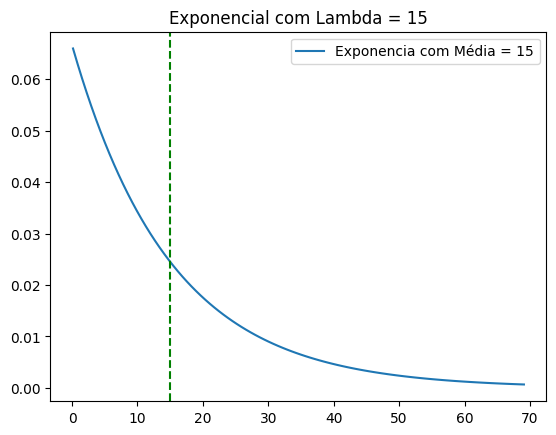

In [25]:
# parâmetro da exponencial de alfa
media_a = 15
l = 1/media_a

# Suporte da variável
suporte = np.linspace(0, 100, 1000)

pdf = st.expon.pdf(x, scale=1/l) 
suporte = np.linspace(st.expon.ppf(scale = 1/l, q=0.01),st.expon.ppf(scale = 1/l,q =0.99),100)
sns.lineplot(x = suporte,y=st.expon.pdf(scale=1/l, x=suporte), label=f'Exponencia com Média = {media_a}')
plt.axvline(media_a,color='green',linestyle='--')
plt.title('Exponencial com Lambda = 15')

Text(0.5, 1.0, 'Exponencial com Lambda = 15')

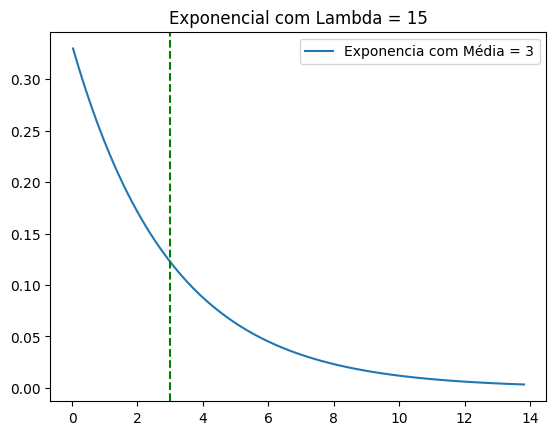

In [26]:
# parâmetro da exponencial de beta
media_b = 3
l = 1/media_b

# Suporte da variável
suporte = np.linspace(0, 100, 1000)

pdf = st.expon.pdf(x, scale=1/l) 
suporte = np.linspace(st.expon.ppf(scale = 1/l, q=0.01),st.expon.ppf(scale = 1/l,q =0.99),100)
sns.lineplot(x = suporte,y=st.expon.pdf(scale=1/l, x=suporte), label=f'Exponencia com Média = {media_b}')
plt.axvline(media_b,color='green',linestyle='--')
plt.title('Exponencial com Lambda = 15')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, lambda]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, lambda]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 39 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, lambda]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 111 seconds.
We recommend running at least 4 chains for robust computation of con

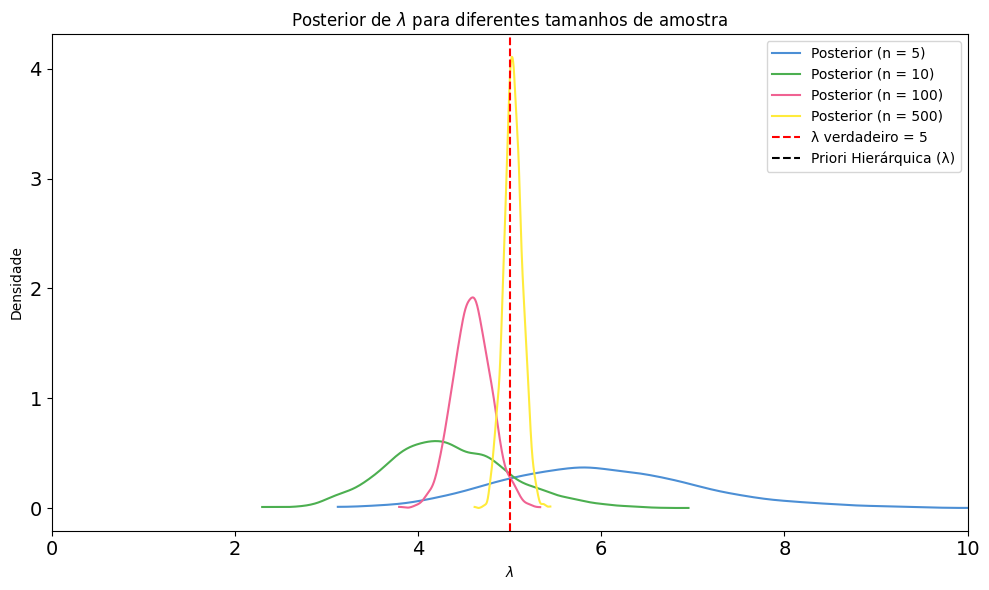

In [69]:
# 1. Parâmetro verdadeiro da Poisson
lambda_verdadeiro = 5

# 2. Tamanhos de amostra para o experimento
tamanhos_amostra = [5, 10, 100, 500]

# 3. Preparar figura
fig, ax = plt.subplots(figsize=(10, 6))

# 4. Loop sobre tamanhos de amostra
for i, n in enumerate(tamanhos_amostra):
    # Gerar dados da distribuição Poisson
    amostra = lista_amostras[i]
    
    # Modelo hierárquico Bayesiano
    with pm.Model() as modelo:
        # Nivel 3: Prioris para alfa e beta
        alpha = pm.Exponential('alpha', lam=1/15)
        beta = pm.Exponential('beta', lam=1/3)

        # Nivel 2: λ seguinda gama com alfa e beta
        lam = pm.Gamma('lambda', alpha=alpha, beta=beta)

        # Nivel 1: x_i ~ Poisson(lambda)
        x = pm.Poisson('x', mu=lam, observed=amostra)

        # Amostragem
        trace = pm.sample(2000, tune=1000, cores=2, random_seed=42, progressbar=False)
    
    # Obter amostras da posterior de λ
    lambda_posterior = trace.posterior['lambda'].values.flatten()
    
    # Plotar distribuição posterior de λ
    az.plot_dist(
        lambda_posterior,
        label=f'Posterior (n = {n})',
        ax=ax,
        color=cor_amostra[i],
        hist_kwargs={'alpha': 0.4}
    )

# 5. Adicionar linha para o valor verdadeiro de λ
ax.axvline(lambda_verdadeiro, color='red', linestyle='--', label=f'λ verdadeiro = {lambda_verdadeiro}')

# 6. Prior marginal simulada (via amostragem)
with pm.Model() as prior_model:
    alpha = pm.Exponential('alpha', lam=1/15)
    beta = pm.Exponential('beta', lam=1/3)
    lam = pm.Gamma('lambda', alpha=alpha, beta=beta)
    prior_pred = pm.sample_prior_predictive(samples=5000, random_seed=42)

lambda_prior = prior_pred.prior['lambda'].values.flatten()

# Plotar a priori marginal de λ
az.plot_dist(
    lambda_prior,
    label='Priori Hierárquica (λ)',
    ax=ax,
    color='black',
    hist_kwargs={'alpha': 0.4},
    plot_kwargs={'linestyle': '--'}
)

# 7. Finalizar gráfico
ax.set_title('Posterior de $\\lambda$ para diferentes tamanhos de amostra')
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('Densidade')
ax.set_xlim((0,10))
ax.legend()
plt.tight_layout()
plt.show()

## Análise das Diferentes Prioris

conju com tamanho 5
conju com tamanho 10
conju com tamanho 100
conju com tamanho 500
jef com tamanho 5
jef com tamanho 10
jef com tamanho 100
jef com tamanho 500


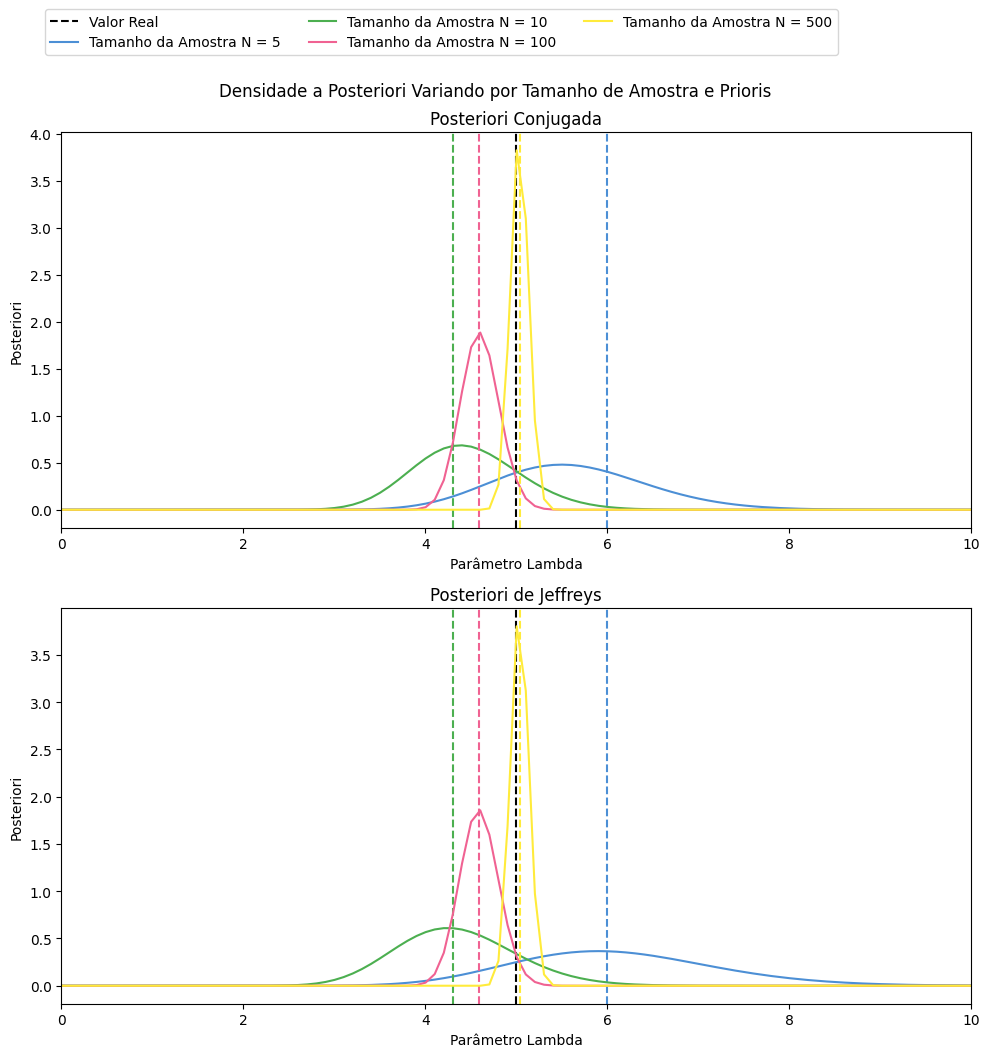

In [63]:
# Vendo as verossimilhanças variando numero de sucessos

titulos = ['Posteriori Conjugada','Posteriori de Jeffreys']
tit = 0

prioris = [0,1]
priori = prioris[0]

fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (10, 10))

for ax in axs.flatten():
    
    ax.set_title(titulos[tit])
    tit += 1
    
    a = 15
    b = 3

    ax.axvline(x=a/b, color='black', linestyle='--', label='Valor Real')

    i = 0

    for amostra in lista_amostras:
        x = amostra
        n = len(x)

        suporte = np.linspace(0,10,1000)

        if priori == 0:
            df_gama = posteriori_conjugada(a,b,x,n)
        elif priori == 1:
            df_gama = posteriori_jeffreys(a,b,x,n)

        sns.lineplot(data = df_gama, x = 'x', y = 'p_x', label=f'Tamanho da Amostra N = {n}', color=cor_amostra[i],ax=ax)
        ax.axvline(x = sum(x)/n, linestyle='--', color=cor_amostra[i])

        i +=1
    ax.set_xlim((0,10))
    ax.set_xlabel('Parâmetro Lambda')
    ax.set_ylabel('Posteriori')
    
    ax.legend_.remove() if hasattr(ax, 'legend_') and ax.legend_ else None
    
    priori += 1

fig.suptitle('Densidade a Posteriori Variando por Tamanho de Amostra e Prioris')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=3, bbox_to_anchor=(0.85, 1))

plt.tight_layout()

## Análise Final

A posteriori com priori conjugada virou uma $Gama(\sum_{i=1}^n x_i + \alpha, n + \beta)$, onde $\alpha = 15$ e $\beta = 3$ e por priori de Jeffreys virou $Gama(\sum_{i=1}^n x_i + \frac{1}{2}, n)$. 

Para $n$ relativamente pequeno, as posterioris possuem diferença, porém, à medida em que $n$ cresce, as gamas se tornam muito semelhantes, com parâmetros muito próximos.

Sabemos que a média da gama é 

$$
E(Y) = \frac{\alpha}{\beta}
$$

Para a posteriori com priori conjugada temos

$$
E(P_1) = \frac{\alpha}{\beta} = \frac{\sum_{i=1}^n x_i + \alpha}{n + \beta}
$$

Para a posteriori com priori de Jeffreys temos

$$
E(P_2) = \frac{\alpha}{\beta} = \frac{\sum_{i=1}^n x_i + \frac{1}{2}}{n}
$$

À medida em que $n$ cresce, as médias ficam cada vez mais próximas, dado que $\alpha$ e $\beta$ são constantes.